In [1]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from boiler.constants import column_names
from boiler.data_processing.beetween_filter_algorithm import FullClosedTimestampFilterAlgorithm
from dateutil.tz import gettz

import config

In [2]:
def smooth(x, window_len):
    window_processor = getattr(np, "hamming")(window_len)
    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    x = np.convolve(window_processor / window_processor.sum(), s, mode='valid')
    x = x[(window_len // 2 - 1 + (window_len % 2)):-(window_len // 2)]
    return x

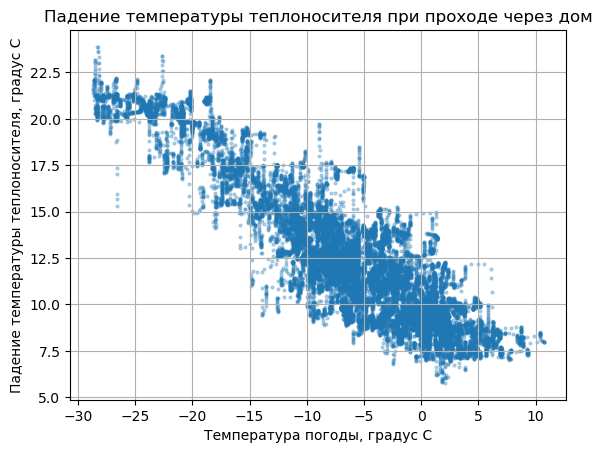

In [3]:
start_datetime = datetime.datetime(2019, 2, 2, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
end_datetime = datetime.datetime(2019, 4, 1, 0, 0, 0, tzinfo=gettz(config.DEFAULT_TIMEZONE))
home_t_smooth_size = 10
wt_smooth_size = 3

dataset_name = "engelsa_37.pickle"
lag = 1

start_datetime = pd.Timestamp(start_datetime)
end_datetime = pd.Timestamp(end_datetime)

filter_algorithm = FullClosedTimestampFilterAlgorithm()

home_df = pd.read_pickle(f"{config.APARTMENT_HOUSE_PREPROCESSED_DATASETS_HEATING_CIRCUIT_DIR}\\{dataset_name}")
home_df = filter_algorithm.filter_df_by_min_max_timestamp(home_df, start_datetime, end_datetime)

home_forward_temp = home_df[column_names.FORWARD_TEMP].to_numpy()
home_forward_temp = smooth(home_forward_temp, home_t_smooth_size)

home_backward_temp = home_df[column_names.BACKWARD_TEMP].to_numpy()
home_backward_temp = smooth(home_backward_temp, home_t_smooth_size)

moved_backward_temp = home_backward_temp[:-lag]
moved_forward_temp = home_forward_temp[lag:]
temp_delta = moved_forward_temp-moved_backward_temp

weather_df = pd.read_pickle(f"{config.WEATHER_PREPROCESSED_DATASET_PATH}")
weather_df = filter_algorithm.filter_df_by_min_max_timestamp(weather_df, start_datetime, end_datetime)
weather_temp = weather_df[column_names.WEATHER_TEMP].to_numpy()

#weather_temp = smooth(weather_temp, wt_smooth_size)
moved_weather_temp = weather_temp[lag:]

plt.grid(True)
plt.title("Падение температуры теплоносителя при проходе через дом")
plt.scatter(moved_weather_temp, temp_delta, s=4, alpha=0.3)
plt.xlabel("Температура погоды, градус С")
plt.ylabel("Падение температуры теплоносителя, градус С")
plt.show()

In [4]:
window_size_back = 180

weather_column = "WEATHER_TEMP"
temp_delta_column = "TEMP_DELTA"
home_forward_column = "HOME_FORWARD"
history_wtd_column = "HISTORY_WTD"
history_wt_column = "HISTORY_WT"
history_home_forward_column = "HISTORY_HOME_FORWARD"
history_home_forward_td_column = "HISTORY_HOME_FORWARD_TD"

correlation_df = pd.DataFrame({
    temp_delta_column: temp_delta[window_size_back:],
    
    weather_column: moved_weather_temp[window_size_back:],
    history_wt_column: moved_weather_temp[:-window_size_back],
    history_wtd_column: (moved_weather_temp[:-window_size_back]-moved_weather_temp[window_size_back:])/window_size_back,
    
    home_forward_column: moved_forward_temp[window_size_back:],
    history_home_forward_column: moved_forward_temp[:-window_size_back],
    history_home_forward_td_column: (moved_forward_temp[:-window_size_back]-moved_forward_temp[window_size_back:])/window_size_back
})

XGB MSE 0.29441238530003716
Lin REG MSE 1.587404642945221


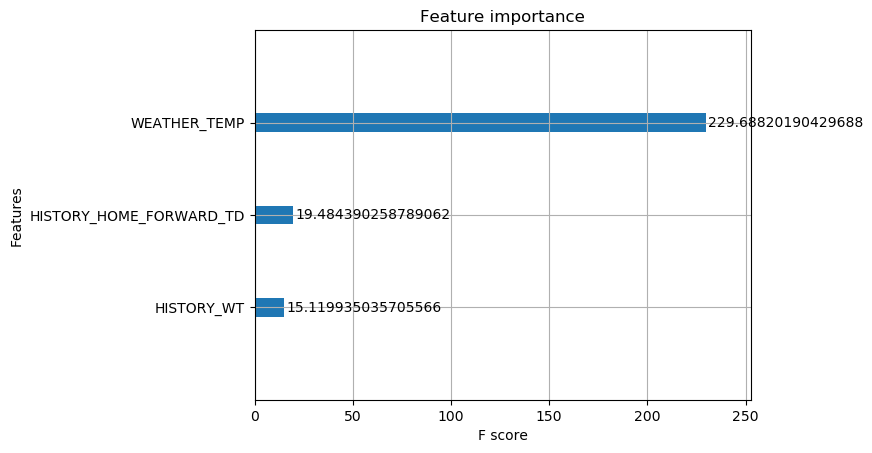

In [5]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression

X = correlation_df[[
    #home_forward_column,
    #history_home_forward_column,
    history_home_forward_td_column,
    weather_column,
    history_wt_column,
    #history_wtd_column,
]]
Y = correlation_df[[temp_delta_column]]


seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = MSE(y_test, y_pred)
print(f"XGB MSE {mse}")
xgboost.plot_importance(model, importance_type="gain")

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred2 = lin_reg.predict(X_test)
mse = MSE(y_test, y_pred2)
print(f"Lin REG MSE {mse}")

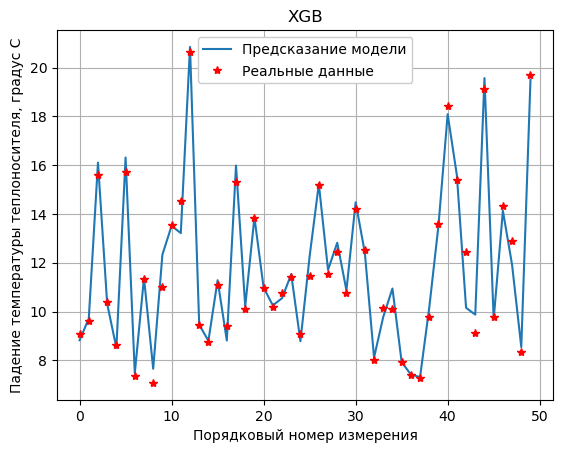

In [6]:
plot_count = 50
plot_start = 10

plt.title("XGB")
plt.grid(True)
plt.plot(range(plot_count), y_pred[plot_start:plot_start+plot_count], label="Предсказание модели")
plt.plot(range(plot_count), y_test[plot_start:plot_start+plot_count], "*r", label="Реальные данные")
plt.legend(framealpha=1, frameon=True)
plt.ylabel("Падение температуры теплоносителя, градус C")
plt.xlabel("Порядковый номер измерения")
plt.show()

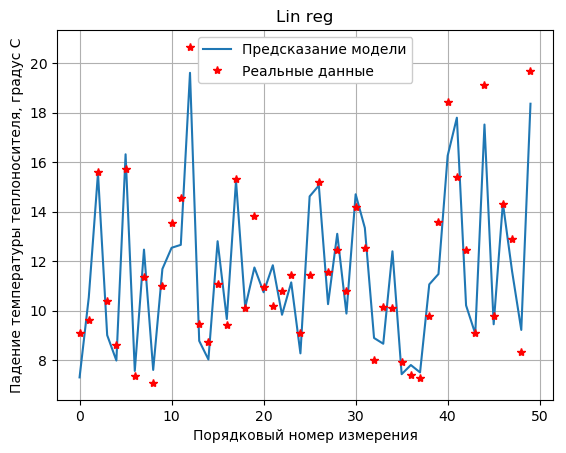

In [7]:
plot_count = 50
plot_start = 10

plt.title("Lin reg")
plt.grid(True)
plt.plot(range(plot_count), y_pred2[plot_start:plot_start+plot_count], label="Предсказание модели")
plt.plot(range(plot_count), y_test[plot_start:plot_start+plot_count], "*r", label="Реальные данные")
plt.legend(framealpha=1, frameon=True)
plt.ylabel("Падение температуры теплоносителя, градус C")
plt.xlabel("Порядковый номер измерения")
plt.show()